# Example for usage of tools and configurations
This notebook is an example of how simulation tools, configurations, and reporting can be done harmoniously if a common structure is established. <br>
Note that this structure is commonly seen among large software teams that are constantly co-developing and producing/maintaining production code. <br>
<br>
*This notebook represents a report that could be the artifact of an analysis informing science impact of a given parameter.*

## Load dependencies

In [1]:
# load dependencies for this report
import matplotlib.pyplot as plt
import utils_config
import warnings

warnings.simplefilter("always")
import config_stp  # must be pip installed
import config_project_template  # must be pip installed

## Import simulation Tool(s)
For the sake of this demonstration an example_tool.py method was located in the same directory as this file.<br>
A more representative example would incorporate importing a more realistic simulation tool such as one of the exposure time calculators.

In [2]:
import example_tool

Display the git hash being executed so there is traceability for reproducing the result in the future. <br>
The config_utils package provides a single function to report this for the standard config repos. 


In [3]:
output = utils_config.check_imports_and_versions(globals().items())

Module         Imported Installed_Version    Branch  is_dirty()?
-------------- -------- -------------------- ------- -----------
config_stp     True     0.0.post112+g9a50d77 N/A     False      
config_um      False    0.0.post7+g7669945   develop False      
config_stp_wcc False    Not_Installed        N/A     False      
config_stp_esc False    Not_Installed        N/A     False      
etc_wcc        False    Not_Installed        N/A     False      
etc_esc        False    Not_Installed        N/A     False      


It can also be used to produce the same report for other repos of interest.<br>
In this case the repo is flagged as dirty because this notebook is being modified.

In [4]:
output = utils_config.check_imports_and_versions(
    globals().items(), modules_to_check=["config_project_template"]
)

Module                  Imported Installed_Version             Branch                    is_dirty()?
----------------------- -------- ----------------------------- ------------------------- -----------
config_project_template True     0.0.post13+g576fb05.d20250513 pingraham/example-updates True       


## Load the configuration
Configurations are be stored in packages external to the tools so multiple stakeholders can access them. They can also be used by CI processes that can automatically generate new reports or values and perform analyses when changes to inputs are performed.<br>
Configurations could be stored inside packages (which can be imported) or can just be cloned repositories if people want to interact with the toml files with their own tooling. <br>
The case below uses a locally cloned repository that was imported as a package at the top of this notebook. <br>
<br>
**Note:** This will throw a warning if an environment variable in the configuration is not set. This is explained further in the Appendix of this notebook (at the bottom).

Users can specify if the data is returned as astropy units, or without units.<br>
See the documentation of utils_config.config_loader for more information. <br>
<br>
Here we'll drop the units so we don't need to import astropy.

In [5]:
data = config_project_template.load_config_values("unitless")
print(data)

{'common_params': {'Sensor': {'CMOS_QE': '$UASAL_ARCHIVE/example/path/from/repo/to/file/ZWO_ASI6200MM_Pro_QE_curve.fits', 'CMOS_gain': 4, 'CMOS_read': 3, 'CMOS_well': 50000}, 'Pupils': {'aper_clear_OD': 5.0, 'D_chB_clear_OD': 2.0}, 'sim_settings': {'npix': 4096, 'beamrad': 0.4}}}


/Users/pingraham/anaconda3/envs/configs/lib/python3.13/site-packages/utils_config/config_loader.py:103: UserWarning: Environment variable '$UASAL_ARCHIVE' referenced by 'Sensor -> CMOS_QE' is not set so '$UASAL_ARCHIVE/example/path/from/repo/to/file/ZWO_ASI6200MM_Pro_QE_curve.fits' will not expand. If using 'Sensor -> CMOS_QE' please set '$UASAL_ARCHIVE' and call this method again.  Reference the README for instructions on setting up an environment variable.
  return {k: self._expand_env_vars(v, path + [k]) for k, v in config.items()}


We can also import other configurations and draw from them

In [6]:

data_stp = config_stp.load_config_values("unitless")

The installed version of the package can be found by printing the version.<br>
Having these displayed in the analysis report aids in the reproduction of the results at future times.

In [7]:
print(f"{config_project_template.__version__=}")
print(f"{config_stp.__version__=}")

config_project_template.__version__='0.0.post13+g576fb05.d20250513'
config_stp.__version__='0.0.post112+g9a50d77'


## Begin Analysis

In this case, we consider the example where we want to iterate over a configuration value and examine the result<br>
In this example let's consider changing the slew speed and we'll run that through our analysis tool see how that affects how long to get to and acquire a target.

In [8]:
print(
    f"The baseline slew speed is {data_stp['observatory']['motion']['slew_avg_speed']}"
)

speeds = [0.1, 0.2, 0.5, 0.6, 0.8, 1, 2, 4, 6, 10]  # [Celsius]

slew_distance = 50  # degrees

The baseline slew speed is 0.44 degree/second


Instantiate example tool class

In [9]:
example_class = example_tool.exampleTool()

Initialized


Loop over the variable being iterated upon and modify the configuration locally

In [10]:
results = {"speed": [], "sim_results": [], "config": []}
for s in speeds:
    data_stp["observatory"]["motion"]["slew_avg_speed"] = s
    run_result = example_class.run_sim(slew_distance, config=data_stp)
    results["config"].append(data_stp)
    results["speed"].append(s)
    results["sim_results"].append(run_result)

Running Simulation with speed of 0.1!
Running Simulation with speed of 0.2!
Running Simulation with speed of 0.5!
Running Simulation with speed of 0.6!
Running Simulation with speed of 0.8!
Running Simulation with speed of 1!
Running Simulation with speed of 2!
Running Simulation with speed of 4!
Running Simulation with speed of 6!
Running Simulation with speed of 10!


## Perform some analysis
For example, one could make a plot and look at the results

Text(0.5, 0, 'slew speed [deg/s]')

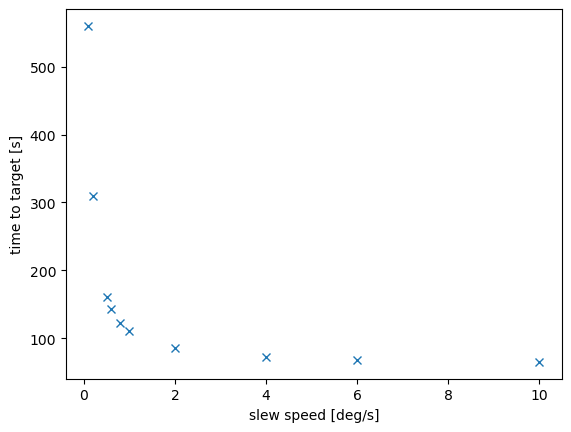

In [11]:
x = results["speed"]
y = results["sim_results"]
plt.plot(x, y, "x")
plt.ylabel("time to target [s]")
plt.xlabel("slew speed [deg/s]")

## Report the take-home points in an obvious manner

In [12]:
print(
    "The  acquisition overhead starts to dominate over slew speeds when the speed is ~1.5 degrees per second"
)

The  acquisition overhead starts to dominate over slew speeds when the speed is ~1.5 degrees per second


### Appendix

There exist cases where large files are referenced from within a configuration file but are not stored inside the support_data folder in the repository. At the time of writing, only the wavefront error maps for optical surfaces meet this criteria, however, there exist analyses that access data files that are located via environment variables.<br>
For the UASAL group, we have created a repository (uasal_archive) to hold large files, or files that are commonly accessed but do not make sense to associate with a configuration repository. An example of this are Pickles stellar models. <br>
If you have this environment variable set on your computer, then config_utils will automatically replace the environment variable in the config file by what is set in your local environment. If a config file contains a reference to an environment variable that is not set, then it will throw a warning. <br>
For example, the following will throw a warning as the environment variable is not declared.

In [13]:
data = config_project_template.load_config_values()

/Users/pingraham/anaconda3/envs/configs/lib/python3.13/site-packages/utils_config/config_loader.py:103: UserWarning: Environment variable '$UASAL_ARCHIVE' referenced by 'Sensor -> CMOS_QE' is not set so '$UASAL_ARCHIVE/example/path/from/repo/to/file/ZWO_ASI6200MM_Pro_QE_curve.fits' will not expand. If using 'Sensor -> CMOS_QE' please set '$UASAL_ARCHIVE' and call this method again.  Reference the README for instructions on setting up an environment variable.
  return {k: self._expand_env_vars(v, path + [k]) for k, v in config.items()}


If we set the environment variable, then the path is populated correctly and the warning will not appear.<br>
Note that for this example we set the environment variable via Python which is not recommended.

In [14]:
import os

os.environ["UASAL_ARCHIVE"] = "/path/to/uasal_config"

In [15]:
data = config_project_template.load_config_values()

The path will now be populated

In [16]:
data["common_params"]["Sensor"]["CMOS_QE"]

'/path/to/uasal_config/example/path/from/repo/to/file/ZWO_ASI6200MM_Pro_QE_curve.fits'